In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

###
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define the distiller model by gpt
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
path = '/content/drive/My Drive/Aravind eye dataset/aptos2019-blindness-detection/train_split'

In [4]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models

# Load DenseNet-121 model without the top layers (pre-trained on ImageNet)
MobileNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the teacher model
teacher = models.Sequential([
    MobileNetV2_model,                  # MobileNetV2 base model
    layers.GlobalAveragePooling2D(),    # Reduces dimensionality (spatial pooling)
    layers.Dropout(0.2),                # Dropout to prevent overfitting
    layers.Dense(1024, activation='relu'), # Fully connected layer with ReLU activation
    layers.Dropout(0.2),                # Dropout
    layers.Dense(512, activation='relu'),  # Another dense layer with ReLU
    layers.Dense(5, activation='softmax')  # Final output layer (assuming 5 classes)
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

# Clone the student model for scratch training comparison
student_scratch = models.clone_model(student)

# Image data generators
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 600)            │        39,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,293 (1.76 MB)

 Trainable params: 460,293 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [5]:
import tensorflow as tf
from tensorflow import keras # Import the keras module

#Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-10 14:55:30.179930:

92/92 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - sparse_categorical_accuracy: 0.4984 - distillation_loss: 0.0240 - loss: 0.2000 - student_loss: 1.2973 - val_sparse_categorical_accuracy: 0.6279 - val_loss: 0.2000 - val_student_loss: 1.0800
Epoch 2/25


2024-09-10 15:01:16.705453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:01:28.972009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - sparse_categorical_accuracy: 0.6640 - distillation_loss: 0.0288 - loss: 0.2000 - student_loss: 1.0645 - val_sparse_categorical_accuracy: 0.6813 - val_loss: 0.2000 - val_student_loss: 1.0199
Epoch 3/25


2024-09-10 15:06:58.691595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:07:10.465546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - sparse_categorical_accuracy: 0.7077 - distillation_loss: 0.0293 - loss: 0.2000 - student_loss: 1.0111 - val_sparse_categorical_accuracy: 0.6949 - val_loss: 0.2000 - val_student_loss: 0.9146
Epoch 4/25


2024-09-10 15:12:40.831086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-10 15:12:49.668030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - sparse_categorical_accuracy: 0.7049 - distillation_loss: 0.0290 - loss: 0.2000 - student_loss: 1.0031 - val_sparse_categorical_accuracy: 0.7086 - val_loss: 0.2000 - val_student_loss: 0.9308
Epoch 5/25


2024-09-10 15:18:26.843578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-10 15:18:42.241098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - sparse_categorical_accuracy: 0.7209 - distillation_loss: 0.0295 - loss: 0.2000 - student_loss: 0.9965 - val_sparse_categorical_accuracy: 0.7004 - val_loss: 0.2000 - val_student_loss: 0.7841
Epoch 6/25


2024-09-10 15:24:17.516598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:24:28.937633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - sparse_categorical_accuracy: 0.7013 - distillation_loss: 0.0295 - loss: 0.2000 - student_loss: 1.0114 - val_sparse_categorical_accuracy: 0.6908 - val_loss: 0.2000 - val_student_loss: 1.0147
Epoch 7/25


2024-09-10 15:29:59.203596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:30:10.265309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 345s 4s/step - sparse_categorical_accuracy: 0.6938 - distillation_loss: 0.0297 - loss: 0.2000 - student_loss: 0.9921 - val_sparse_categorical_accuracy: 0.6936 - val_loss: 0.2000 - val_student_loss: 1.1549
Epoch 8/25


2024-09-10 15:35:45.398394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:35:57.690663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - sparse_categorical_accuracy: 0.7230 - distillation_loss: 0.0291 - loss: 0.2000 - student_loss: 0.9920 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 0.9364
Epoch 9/25


2024-09-10 15:41:28.365248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-10 15:41:40.283473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-10 15:41:43.269871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - sparse_categorical_accuracy: 0.7227 - distillation_loss: 0.0294 - loss: 0.2000 - student_loss: 0.9809 - val_sparse_categorical_accuracy: 0.7155 - val_loss: 0.2000 - val_student_loss: 0.8973
Epoch 10/25


2024-09-10 15:47:16.096000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 15:47:27.252007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 1308s 14s/step - sparse_categorical_accuracy: 0.7196 - distillation_loss: 0.0298 - loss: 0.2000 - student_loss: 0.9817 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.9144
Epoch 11/25


2024-09-10 16:09:03.086579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 16:09:49.290266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-10 16:09:58.648482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 6404s 70s/step - sparse_categorical_accuracy: 0.7290 - distillation_loss: 0.0293 - loss: 0.2000 - student_loss: 0.9825 - val_sparse_categorical_accuracy: 0.6895 - val_loss: 0.2000 - val_student_loss: 1.0354
Epoch 12/25


2024-09-10 17:55:48.562310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 17:55:59.175346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - sparse_categorical_accuracy: 0.7131 - distillation_loss: 0.0298 - loss: 0.2000 - student_loss: 0.9757 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 1.0415
Epoch 13/25


2024-09-10 18:01:30.162518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:01:42.095403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - sparse_categorical_accuracy: 0.7275 - distillation_loss: 0.0295 - loss: 0.2000 - student_loss: 0.9794 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 0.8160
Epoch 14/25


2024-09-10 18:07:11.114080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:07:21.720453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - sparse_categorical_accuracy: 0.7176 - distillation_loss: 0.0296 - loss: 0.2000 - student_loss: 0.9698 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.9145
Epoch 15/25


2024-09-10 18:13:39.124463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:13:49.146903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - sparse_categorical_accuracy: 0.7066 - distillation_loss: 0.0295 - loss: 0.2000 - student_loss: 0.9671 - val_sparse_categorical_accuracy: 0.7045 - val_loss: 0.2000 - val_student_loss: 0.8772
Epoch 16/25


2024-09-10 18:19:59.499384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:20:09.876543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - sparse_categorical_accuracy: 0.7205 - distillation_loss: 0.0303 - loss: 0.2000 - student_loss: 0.9520 - val_sparse_categorical_accuracy: 0.7127 - val_loss: 0.2000 - val_student_loss: 1.0770
Epoch 17/25


2024-09-10 18:26:27.961196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:26:38.213159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - sparse_categorical_accuracy: 0.7140 - distillation_loss: 0.0303 - loss: 0.2000 - student_loss: 0.9571 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 0.9903
Epoch 18/25


2024-09-10 18:32:55.918883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:33:06.952811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - sparse_categorical_accuracy: 0.7140 - distillation_loss: 0.0298 - loss: 0.2000 - student_loss: 0.9616 - val_sparse_categorical_accuracy: 0.7073 - val_loss: 0.2000 - val_student_loss: 0.6924
Epoch 19/25


2024-09-10 18:39:34.381281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:39:45.134722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - sparse_categorical_accuracy: 0.7068 - distillation_loss: 0.0303 - loss: 0.2000 - student_loss: 0.9526 - val_sparse_categorical_accuracy: 0.7059 - val_loss: 0.2000 - val_student_loss: 1.0428
Epoch 20/25


2024-09-10 18:45:58.310011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:46:10.967426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - sparse_categorical_accuracy: 0.7384 - distillation_loss: 0.0304 - loss: 0.2000 - student_loss: 0.9486 - val_sparse_categorical_accuracy: 0.6977 - val_loss: 0.2000 - val_student_loss: 0.9409
Epoch 21/25


2024-09-10 18:51:39.896378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:51:51.637860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - sparse_categorical_accuracy: 0.7173 - distillation_loss: 0.0299 - loss: 0.2000 - student_loss: 0.9524 - val_sparse_categorical_accuracy: 0.7004 - val_loss: 0.2000 - val_student_loss: 1.0478
Epoch 22/25


2024-09-10 18:57:21.712863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 18:57:32.629771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - sparse_categorical_accuracy: 0.7133 - distillation_loss: 0.0300 - loss: 0.2000 - student_loss: 0.9523 - val_sparse_categorical_accuracy: 0.7045 - val_loss: 0.2000 - val_student_loss: 0.8904
Epoch 23/25


2024-09-10 19:03:04.817503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 19:03:17.542312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - sparse_categorical_accuracy: 0.7337 - distillation_loss: 0.0304 - loss: 0.2000 - student_loss: 0.9426 - val_sparse_categorical_accuracy: 0.7182 - val_loss: 0.2000 - val_student_loss: 1.2873
Epoch 24/25


2024-09-10 19:08:46.619021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 19:08:57.508628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - sparse_categorical_accuracy: 0.7113 - distillation_loss: 0.0303 - loss: 0.2000 - student_loss: 0.9402 - val_sparse_categorical_accuracy: 0.6977 - val_loss: 0.2000 - val_student_loss: 1.0774
Epoch 25/25


2024-09-10 19:14:25.712157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-10 19:14:37.304574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - sparse_categorical_accuracy: 0.7026 - distillation_loss: 0.0304 - loss: 0.2000 - student_loss: 0.9444 - val_sparse_categorical_accuracy: 0.6922 - val_loss: 0.2000 - val_student_loss: 0.8076


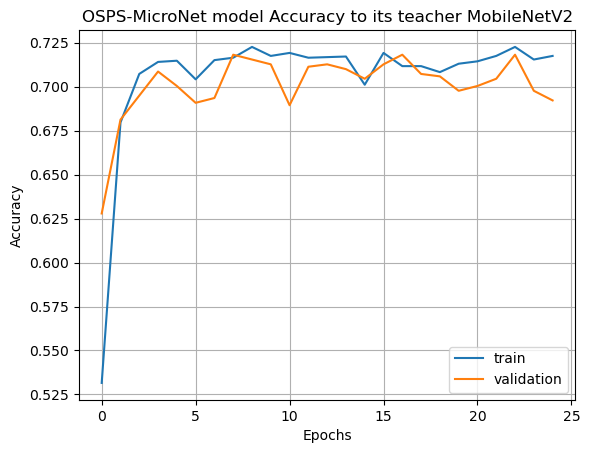

In [6]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher MobileNetV2')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [7]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher MobileNetV2 model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher MobileNetV2 model is 71.81942462921143
